In [32]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(2e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'


initial_temperature = 10.0
initial_relative_bias = 0.1
bias_is_trainable = True
U0 = torch.randn(n_classes, dim, device = device_str)

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, losses_history, x_final = experiment.train(
    relative_bias=initial_relative_bias,
    temperature=initial_temperature,
    trainable_bias=bias_is_trainable,
    fixed_U=U0,
    initial_x=0.5
)

print("\n--- Training Complete ---")
print(f"Final Loss: {losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Delta: {torch.sigmoid(x_final).item():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_epochs=20000
Loss params: temperature=10.0, relative_bias=0.1, trainable_bias=True
[100/20000]  loss=0.0106  δ=0.7487  T=15.1188  rb=0.0785
[200/20000]  loss=0.0014  δ=0.8194  T=27.2737  rb=0.2002
[300/20000]  loss=0.0004  δ=0.8386  T=34.3750  rb=0.2417
[400/20000]  loss=0.0002  δ=0.8477  T=39.0770  rb=0.2638
[500/20000]  loss=0.0001  δ=0.8533  T=42.5769  rb=0.2782
[600/20000]  loss=0.0001  δ=0.8573  T=45.3751  rb=0.2886
[700/20000]  loss=0.0001  δ=0.8603  T=47.7158  rb=0.2965
[800/20000]  loss=0.0000  δ=0.8627  T=49.7350  rb=0.3029
[900/20000]  loss=0.0000  δ=0.8646  T=51.5158  rb=0.3082
[1000/20000]  loss=0.0000  δ=0.8663  T=53.1128  rb=0.3127
[1100/20000]  loss=0.0000  δ=0.8677  T=54.5639  rb=0.3166
[1200/20000]  loss=0.0000  δ=0.8690  T=55.8967  rb=0.3201
[1300/20000]  loss=0.0000  δ=0.8702  T=57.1314  rb=0.3232
[1400/20000]  loss=0.0000  δ=0.8712  T=58.2838  rb=0.3259
[1500/20000]  loss=0.0000  δ=0.8721  T=59.3659

<function matplotlib.pyplot.show(close=None, block=None)>

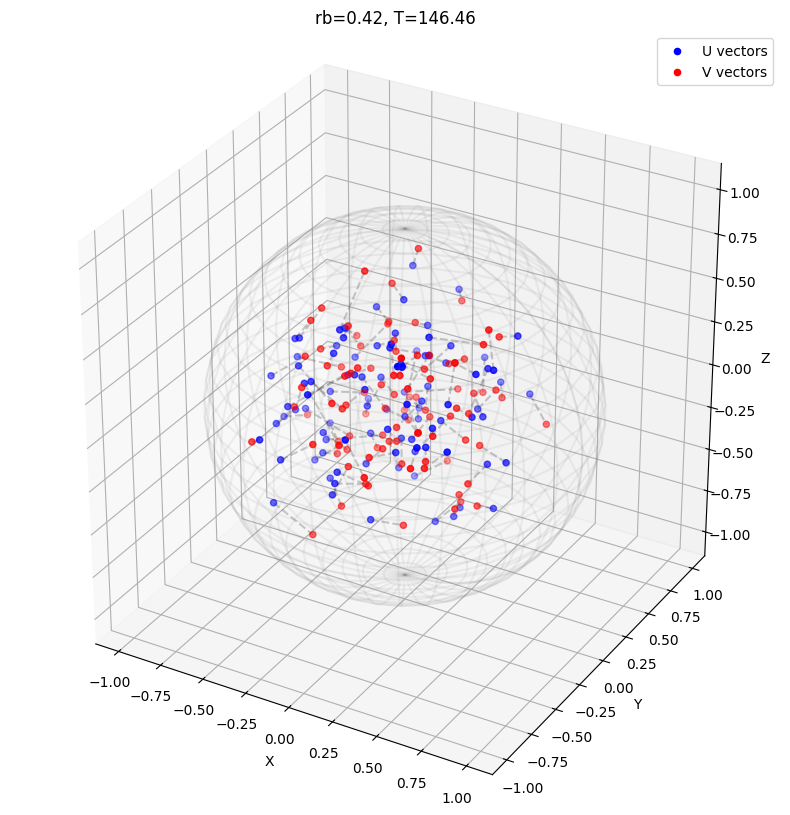

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show

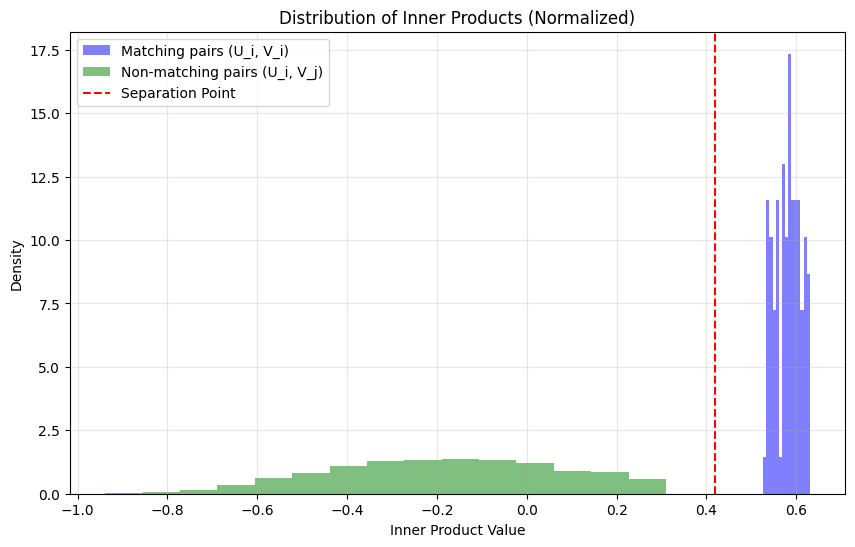

In [49]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (U_i, V_i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (U_i, V_j)', color='green', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Distribution of Inner Products (Normalized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
